In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import SVG
from graphviz import Source
import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
import xgboost as xgb
import warnings
# Import mlflow
import mlflow
import mlflow.sklearn
warnings.filterwarnings("ignore")
%matplotlib inline
from preprocess import preprocess

In [14]:
df = pd.read_csv('data/dataset.csv')
df = preprocess(df, include_target=True)


In [15]:
df.head()

,Patient age quantile,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),...,pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis),SARS-Cov-2 exam result
0,13,999999.000000,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.00000,999999.000000,999999.000000,...,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,0
1,17,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.09461,-0.223767,-0.292269,...,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,0
2,8,999999.000000,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.00000,999999.000000,999999.000000,...,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,0
3,5,999999.000000,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.00000,999999.000000,999999.000000,...,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,0
4,15,999999.000000,999999.00000,999999.000000,999999.000000,999999.000000,999999.000000,999999.00000,999999.000000,999999.000000,...,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,999999.0,0


### Modeling

I will try to identify covid-19 by applying several models combined with random over sampler and random under sampler. The samplers will balance the dataset, so it should reduce the bias of my models. I will also apply xgboost with hyperparameter tuning.

In [16]:
classifiers = {'Logistic Regression' : LogisticRegression(),
               'KNN': KNeighborsClassifier(),
               'Decision Tree': DecisionTreeClassifier(),
               'Random Forest': RandomForestClassifier(),
               'AdaBoost': AdaBoostClassifier(),
               'SVM': SVC()}

samplers = {'Random_under_sampler': RandomUnderSampler(),
            'Random_over_sampler': RandomOverSampler()}


In [19]:
def df_split(df, target='SARS-Cov-2 exam result'):
    df = df.fillna(999)
    x = df.drop(target, axis=1)
    y = df[target]    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)                          
    return x_train, x_test, y_train, y_test

def train_clfs(df, classifiers, samplers):

    x_train, x_test, y_train, y_test = df_split(df)

    names_samplers = []
    names_clfs = []
    results_train_cv_roc_auc = []
    results_train_cv_recall = []
    results_train_cv_accuracy = []
    results_test_roc_auc = []
    results_test_recall = []
    results_test_accuracy = []

    for name_sampler, sampler in samplers.items():
        print(f'Sampler: {name_sampler}\n')
        for name_clf, clf in classifiers.items():
            with mlflow.start_run(run_name=f"{name_sampler}-{name_clf}"):
                print(f'Classifier: {name_clf}\n')

                pipeline = Pipeline([('sampler', sampler),
                                     ('clf', clf)])

                cv_auc = cross_val_score(pipeline, x_train, y_train, cv=10, scoring='roc_auc') 
                cv_rec = cross_val_score(pipeline, x_train, y_train, cv=10, scoring='recall')                                
                cv_acc = cross_val_score(pipeline, x_train, y_train, cv=10, scoring='accuracy')        

                pipeline.fit(x_train, y_train)        
                y_pred = pipeline.predict(x_test)

                names_samplers.append(name_sampler)
                names_clfs.append(name_clf)
                results_train_cv_roc_auc.append(cv_auc)
                results_train_cv_recall.append(cv_rec)
                results_train_cv_accuracy.append(cv_acc)
                results_test_roc_auc.append(roc_auc_score(y_test, y_pred))
                results_test_recall.append(recall_score(y_test, y_pred))
                results_test_accuracy.append(accuracy_score(y_test, y_pred))
                
                print(f'CV\t-\troc_auc:\t{round(cv_auc.mean(), 3)}')
                print(f'CV\t-\trecall:\t\t{round(cv_rec.mean(), 3)}')
                print(f'CV\t-\taccuracy:\t{round(cv_acc.mean(), 3)}')

                print(f'Test\t-\troc_auc:\t{round(roc_auc_score(y_test, y_pred), 3)}')         
                print(f'Test\t-\trecall:\t\t{round(recall_score(y_test, y_pred), 3)}')          
                print(f'Test\t-\taccuracy:\t{round(accuracy_score(y_test, y_pred), 3)}')      
                print('\n<-------------------------->\n')

                # Log mlflow attributes for mlflow UI

                mlflow.log_metric('CV-roc_auc',round(cv_auc.mean(), 3))
                mlflow.log_metric('CV-recall', round(cv_rec.mean(), 3))
                mlflow.log_metric('CV-accuracy',round(cv_acc.mean(), 3))

                mlflow.log_metric('Test-roc_auc',round(roc_auc_score(y_test, y_pred), 3))         
                mlflow.log_metric('Test-recall',round(recall_score(y_test, y_pred), 3))          
                mlflow.log_metric('Test-accuracy',round(accuracy_score(y_test, y_pred), 3))
                mlflow.sklearn.log_model(pipeline, "model")


    df_results_test = pd.DataFrame(index=[names_clfs, names_samplers], columns=['ROC_AUC', 'RECALL', 'ACCURACY'])
    df_results_test['ROC_AUC'] = results_test_roc_auc
    df_results_test['RECALL'] = results_test_recall
    df_results_test['ACCURACY'] = results_test_accuracy

    return df_results_test

In [20]:
df_results = train_clfs(df, classifiers, samplers)

Sampler: Random_under_sampler

Classifier: Logistic Regression

CV	-	roc_auc:	0.574
CV	-	recall:		0.776
CV	-	accuracy:	0.369
Test	-	roc_auc:	0.555
Test	-	recall:		0.795
Test	-	accuracy:	0.363

<-------------------------->

Classifier: KNN

CV	-	roc_auc:	0.506
CV	-	recall:		0.128
CV	-	accuracy:	0.796
Test	-	roc_auc:	0.532
Test	-	recall:		0.179
Test	-	accuracy:	0.815

<-------------------------->

Classifier: Decision Tree

CV	-	roc_auc:	0.619
CV	-	recall:		0.655
CV	-	accuracy:	0.511
Test	-	roc_auc:	0.598
Test	-	recall:		0.688
Test	-	accuracy:	0.526

<-------------------------->

Classifier: Random Forest

CV	-	roc_auc:	0.629
CV	-	recall:		0.706
CV	-	accuracy:	0.501
Test	-	roc_auc:	0.62
Test	-	recall:		0.768
Test	-	accuracy:	0.501

<-------------------------->

Classifier: AdaBoost

CV	-	roc_auc:	0.622
CV	-	recall:		0.776
CV	-	accuracy:	0.444
Test	-	roc_auc:	0.591
Test	-	recall:		0.741
Test	-	accuracy:	0.47

<-------------------------->

Classifier: SVM

CV	-	roc_auc:	0.554
CV	-	recall:	

### Conclusion

We can check the top 9 pipelines for each metric ROC_AUC, RECALL, and ACCURACY in the test dataset below:

In [15]:
df_plot = pd.concat([df_results.sort_values('ROC_AUC', ascending=False).head(3),
                     df_results.sort_values('RECALL', ascending=False).head(3),
                     df_results.sort_values('ACCURACY', ascending=False).head(3)])

In [16]:
def plot_test(df, xlim_min, xlim_max):

    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,12))
    color = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'navy', 'turquoise', 'darkorange']

    df['ROC_AUC'].plot(kind='barh', ax=ax1, xlim=(xlim_min, xlim_max), title='ROC_AUC', color=color)
    df['RECALL'].plot(kind='barh', ax=ax2, xlim=(xlim_min, xlim_max), title='RECALL', color=color)
    df['ACCURACY'].plot(kind='barh', ax=ax3, xlim=(xlim_min, xlim_max), title='ACCURACY', color=color)
    plt.show()

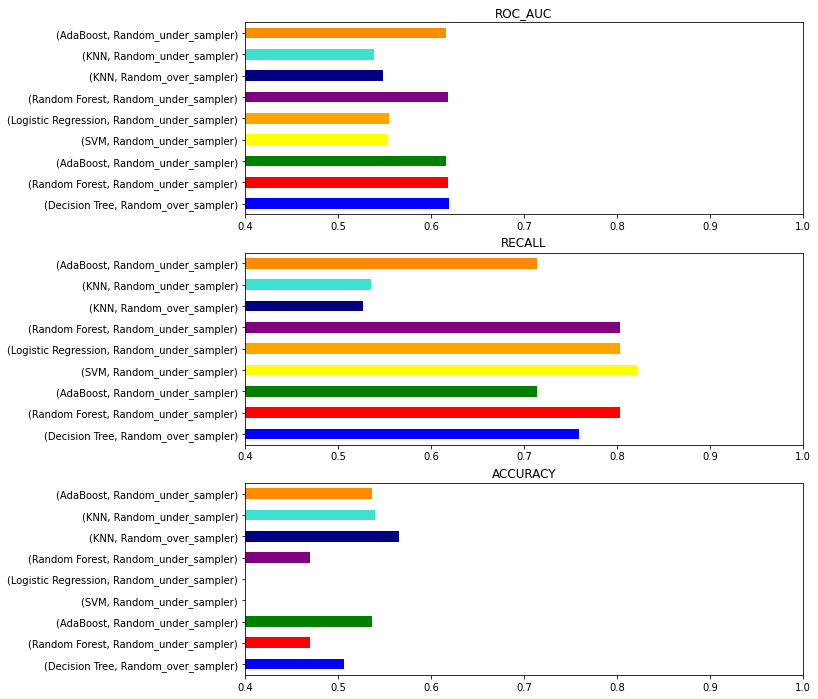

In [17]:
plot_test(df_plot, 0.4, 1)

As we can see, many models performed well according to RECALL, but did not provided good results for ACCURACY.
The choice of the best metric depends on the costs associated to each true or false prediction

<table>
    <th> </th>
    <th style=" border: 1px solid black">Predicted No Covid</th>
    <th style=" border: 1px solid black">Predicted Covid</th>
    <tr style=" border: 1px solid black">
        <td style=" border: 1px solid black"><b>No Covid</b></td>
        <td style=" border: 1px solid black">True Negative</td>
        <td style=" border: 1px solid black">False Positive</td>
    </tr>
    <tr style=" border: 1px solid black">
        <td style=" border: 1px solid black"><b>Covid</b></td>
        <td style=" border: 1px solid black">False Negative</td>
        <td style=" border: 1px solid black">True Positive</td>
    </tr>
</table>


To understand the costs of each value, we can interpret the values of each cell in the confusion matrix as:
- **True Negative:** Model predicted that patient is not infected by covid-19, and he is not. 

**Cost**: Low:- The patient will not need special treatment nor medicaments.

- **False Positive:** Model predicted that patient is infected by covid-19, and he is not.

**Cost**: Medium - The patient will receive special treatment and medicaments unnecessarily.

- **False Negative:**

**Cost**: Very-high - The patient may probably leave the hospital and transmit coronavirus to their colleagues and family, besides risking his life

- **True Positive:**

**Cost**: Medium - The patient will receive special treatment and medicaments.

As we want minimize the risk of false negatives, we should try to choose the models that have high recall. I plotted the confusion matrix of the pipeline `Random Forest + Random Under Sampler` for each threshold.

In [18]:
def plot_confusion_matrix(y_test, y_pred, title='Confusion matrix'):
    
    cm = confusion_matrix(y_test, y_pred)
    classes = ['No Covid', 'Covid']

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, )
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def train_clf_threshold(df, clf, sampler=None):
    thresholds = np.arange(0.1, 1, 0.1)
    
    x_train, x_test, y_train, y_test = df_split(df)
    
    if sampler:
        clf_train = Pipeline([('sampler', sampler),
                              ('clf', clf)])
        
    else:        
        clf_train = clf
            
    clf_train.fit(x_train, y_train)
    y_proba = clf_train.predict_proba(x_test)
    
    plt.figure(figsize=(10,10))

    j = 1
    for i in thresholds:
        y_pred = y_proba[:,1] > i

        plt.subplot(4, 3, j)
        j += 1

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_test,y_pred)
        np.set_printoptions(precision=2)

        print(f"Threshold: {round(i, 1)} | Test Accuracy: {round(accuracy_score(y_test, y_pred), 2)}| Test Recall: {round(recall_score(y_test, y_pred), 2)} | Test Roc Auc: {round(roc_auc_score(y_test, y_pred), 2)}")

        # Plot non-normalized confusion matrix
        plot_confusion_matrix(y_test, y_pred, title=f'Threshold >= {round(i, 1)}')

Threshold: 0.1 | Test Accuracy: 0.19| Test Recall: 1.0 | Test Roc Auc: 0.55
Threshold: 0.2 | Test Accuracy: 0.26| Test Recall: 0.98 | Test Roc Auc: 0.58
Threshold: 0.3 | Test Accuracy: 0.28| Test Recall: 0.97 | Test Roc Auc: 0.59
Threshold: 0.4 | Test Accuracy: 0.36| Test Recall: 0.92 | Test Roc Auc: 0.61
Threshold: 0.5 | Test Accuracy: 0.53| Test Recall: 0.75 | Test Roc Auc: 0.63
Threshold: 0.6 | Test Accuracy: 0.67| Test Recall: 0.46 | Test Roc Auc: 0.58
Threshold: 0.7 | Test Accuracy: 0.85| Test Recall: 0.15 | Test Roc Auc: 0.54
Threshold: 0.8 | Test Accuracy: 0.86| Test Recall: 0.09 | Test Roc Auc: 0.52
Threshold: 0.9 | Test Accuracy: 0.87| Test Recall: 0.06 | Test Roc Auc: 0.51


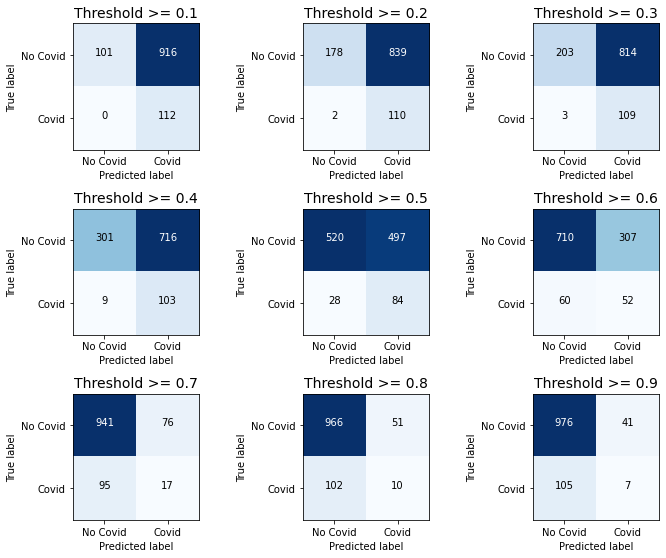

In [19]:
train_clf_threshold(df, RandomForestClassifier(), sampler=RandomUnderSampler())

As we can see, depending on the risk we want to take, we can choose a model and threshold that provide both a high recall and a fair roc-auc.

In [21]:
pipeline = Pipeline([('sampler', RandomOverSampler()),
                                 ('clf', SVC())])

x_train, x_test, y_train, y_test = df_split(df)
pipeline.fit(x_train, y_train)

Pipeline(steps=[('sampler', RandomOverSampler()), ('clf', SVC())])

In [22]:
from joblib import dump

dump(pipeline, 'cov19model.joblib')


['cov19model.joblib']